In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [ ]:
?plt.plot

In [ ]:
PATH="data/bulldozers/"

In [ ]:
!ls {PATH}

In [ ]:
name=123
f'Hello {name}'

In [ ]:
df_raw = pd.read_csv(f'{PATH}Train.csv',
                    low_memory=False,
                    parse_dates=["saledate"])

In [ ]:
def display_all(df):
    with pd.option_context("display.max_rows",1000):
        with pd.option_context("display.max_columns",1000):
            display(df)

In [ ]:
df_raw.head()

In [ ]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

# Initial processing

In [ ]:
?RandomForestRegressor

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice',axis=1), df_raw.SalePrice)

# Feature engineering

In [ ]:
fld = df_raw.saledate

In [ ]:
add_datepart(df_raw,'saledate')
df_raw.saleYear.head()

In [ ]:
df_raw.columns

In [ ]:
df_raw.head()

In [ ]:
train_cats(df_raw)

In [ ]:
df_raw.head()

In [ ]:
df_raw.UsageBand.cat.categories

In [ ]:
# Reorder category
df_raw.UsageBand.cat.set_categories(
    ['High','Medium','Low'], ordered=True,
    inplace=True)

In [ ]:
df_raw.UsageBand.cat.codes

In [ ]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

In [ ]:
os.makedirs('tmp',exist_ok=True)
df_raw.to_feather('tmp/raw')
df_raw.to_csv('tmp/myCsv.csv')

# Pre-processing

In [4]:
# In the future,
df_raw = pd.read_feather('tmp/raw')

In [5]:
# We will replace categorical with their numerical codes, handle missing
# continuous values
df, y, nas = proc_df(df_raw, 'SalePrice')

In [6]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [7]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


In [8]:
# Now let's run our Random forest!
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

KeyboardInterrupt: 

In [9]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 #same as Kaggle's test size
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape



((389125, 66), (389125,), (12000, 66))

In [10]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print (res)

In [11]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 26s, sys: 993 ms, total: 1min 27s
Wall time: 29.5 s
[0.09026857859271457, 0.24773872532229868, 0.9829702593536592, 0.8903936359036942]


### Speeding things up

In [13]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice',subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [15]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3.19 s, sys: 43.8 ms, total: 3.24 s
Wall time: 1.03 s
[0.1038691444834249, 0.3324926849855465, 0.9781898856741583, 0.8025704461702493]


## Single tree

In [16]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 134 ms, sys: 8.05 ms, total: 142 ms
Wall time: 170 ms
[0.4965829795739235, 0.5246832258551872, 0.5014961773561586, 0.5083655198087804]


In [19]:
from sklearn.tree import export_graphviz

In [20]:
draw_tree(m.estimators_[0], df_trn, precision=3)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [21]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10347474072609494, 0.34293031089681963, 0.9783552025192759, 0.7899804515563184]


In [25]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.21034,  9.39266,  8.92266,  9.39266,  9.6486 ,  9.68034,  9.21034,  8.92266, 10.12663,  9.3501 ]),
 9.38569939228724,
 9.104979856318357)

In [26]:
preds.shape

(10, 12000)

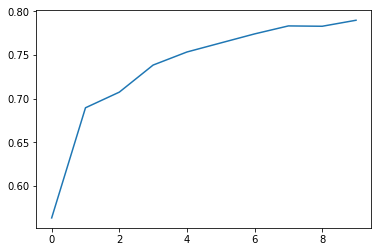

In [28]:
# Go through all the trees and take the mean based on the number of trees
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

# Out-of-bag
The idea here is to fit each row of the training set only using the trees which (randomly) did not use that specific row. Hence we can see if our model generalizes well with the data.

In [29]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.08908016180903149, 0.32636735237546605, 0.98395843160029, 0.809777716580995, 0.884125814070898]


### Subsampling

In [33]:
df_trn, y_trn, _ = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
df_trn.shape, X_train.shape

((401125, 66), (389125, 66))

In [34]:
set_rf_samples(20000)

In [36]:
??set_rf_samples

In [35]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=40)
m.fit(X_train, y_train)
print_score(m)

[0.22724728012563594, 0.2604078008524404, 0.8920724759762463, 0.8788967066146212, 0.8805895300459022]


# Baseline

In [37]:
reset_rf_samples()

In [38]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=40)
m.fit(X_train, y_train)
print_score(m)

[0.07834147074440567, 0.23896432722971925, 0.9871732016536562, 0.8980202079705122, 0.908491113120072]


In [39]:
# trying with min_sample_leaf=3
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=40, min_samples_leaf=3)
m.fit(X_train, y_train)
print_score(m)

[0.11513157342646779, 0.23299042741820572, 0.9722971974950313, 0.9030552868018299, 0.9083722945394401]
